In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)
import torch
from utils.jupyter_utils import get_perclass_count, get_tail_info

In [25]:
# Helper functions
def get_lifted_info(dataset, index_name, threshold):
    count_dict = get_perclass_count(dataset=dataset,
                                    index_dir='indexes/',
                                    index_name=index_name,
                                    verbose=False)
    sorted_classes = count_dict['sorted_classes']
    original = count_dict['train']
    lift_tail = get_perclass_count(dataset=dataset,
                                   index_dir='indexes/',
                                   index_name=index_name+"_lift_tail",
                                   verbose=False)['train']
    lift_random = get_perclass_count(dataset=dataset,
                                     index_dir='indexes/',
                                     index_name=index_name+"_lift_random",
                                     verbose=False)['train']
    tail_class_count, tail_sample_count = get_tail_info(dataset=dataset,
                                                        index_dir='indexes/',
                                                        index_name=index_name,
                                                        threshold=threshold)
    return {
        'sorted_classes': sorted_classes,
        'original': original,
        'lift_tail': lift_tail,
        'lift_random': lift_random,
        'tail_sample_count': tail_sample_count,
        'tail_class_count': tail_class_count,
    }

def get_acc_info(results):
    best_val_epoch = np.argmax(np.array(results['val_acc']))
    best_test_acc = results['test_acc'][best_val_epoch]
    best_test_acc_all = results['test_acc_all'][best_val_epoch]
    return best_val_epoch, best_test_acc, best_test_acc_all

def head_and_tail_acc(macc, lifted_info):
    # macc must be sorted already
    head_macc = macc[:-lifted_info['tail_class_count']]
    tail_macc = macc[-lifted_info['tail_class_count']:]
    return sum(head_macc)/len(head_macc), sum(tail_macc)/len(tail_macc)

In [72]:
# Helper func
def plot_per_class_accuracy(result_dict, dataset, index_name, algo, threshold):
    lifted_info = get_lifted_info(dataset, index_name, threshold)
    curves = {'original': {'macc': [], 'sample': [], 'color': 'r'},
              'lift_tail': {'macc': [], 'sample': [], 'color': 'b'},
#               'lift_random': {'macc': [], 'sample': [], 'color': 'g'}
             }
    
    for mode in curves:
        dir_path = result_dict[dataset][index_name][algo][mode]['result']
        if dir_path is None:
            continue
        
        file_path = os.path.join(dir_path, "results.pth")
        # print(file_path)
        results = torch.load(file_path)
        best_val_epoch, best_test_acc, best_test_acc_all = get_acc_info(results)
        curves[mode]['macc'] = [float(best_test_acc_all[i]) for i in lifted_info['sorted_classes']]
        num_classes = len(curves[mode]['macc'])
        curves[mode]['sample'] = lifted_info[mode]
        curves[mode]['acc'] = float(best_test_acc)
        head_macc, tail_macc = head_and_tail_acc(curves[mode]['macc'], lifted_info)
        curves[mode]['head'] = head_macc
        curves[mode]['tail'] = tail_macc
        print(f"{mode} has head macc {head_macc}; tail macc {tail_macc}; total macc {curves[mode]['acc']}")
        if 'qhat' in results:
            curves[mode]['qhat'] = [float(results['qhat'][best_val_epoch][0][i]) for i in lifted_info['sorted_classes']]
#             print(curves[mode]['qhat'])

    plt.figure(figsize=(15,4), dpi=64, facecolor='w', edgecolor='k')
    labelnames = np.arange(num_classes)
    plt.xticks(list(range(num_classes)), labelnames, rotation=90, fontsize=8);  # Set text labels.
    plt.title(f'{dataset} per-class accuracy vs. per-class #images', fontsize=20)
    ax1 = plt.gca()    
    ax2=ax1.twinx()
    for mode in curves:
        if 'macc' not in curves[mode]:
            continue
        ax1.bar(list(range(num_classes)), curves[mode]['macc'], alpha=0.7, width=1, label=mode, 
#                 edgecolor = "black", 
                color=curves[mode]['color'])
        
    ax1.set_ylabel('accuracy', fontsize=16, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=16)

    ax2.set_ylabel('#images', fontsize=16, color='r')
    for mode in curves:
        if 'sample' not in curves[mode]:
            continue
        ax2.plot(curves[mode]['sample'], linewidth=4, color=curves[mode]['color'])
    ax2.tick_params(axis='y', labelcolor='r', labelsize=16)
    
    ax1.legend(prop={'size': 14})

# Semi-INat Results (Supervised)

In [63]:
result_dict = {
    'semi_inat': {
        'default': {
            'supervised' : {
                'original': {'result': "checkpoints/supervised/semi_inat/08-31-2022-03:06", 'index_name' : 'default'},
                'lift_random': {'result': "checkpoints/supervised/semi_inat_lift_random/09-03-2022-01:09", 'index_name' : 'default_lift_random'},
                'lift_tail': {'result': "checkpoints/supervised/semi_inat_lift_tail/09-09-2022-17:23", 'index_name' : 'default_lift_tail'},
            },
            'debiased' : {
                'original': {'result': "checkpoints/semi_supervised/inat_debiased_2/08-31-2022-22:39", 'index_name' : 'default'},
                'lift_random': {'result': "checkpoints/semi_supervised/inat_debiased_lift_random_2/09-08-2022-22:40", 'index_name' : 'default_lift_random'},
                'lift_tail': {'result': "checkpoints/semi_supervised/inat_debiased_lift_tail_2/09-03-2022-01:04", 'index_name' : 'default_lift_tail'},
            }
        }
    },
    'imagenet127': {
        'default': {
            'supervised' : {
                'original': {'result': "checkpoints/supervised/imagenet127/08-31-2022-03:06", 'index_name' : 'default'},
                'lift_random': {'result': None, 'index_name' : 'default_lift_random'},
                'lift_tail': {'result': "checkpoints/supervised/imagenet127_lift_tail/09-09-2022-17:22", 'index_name' : 'default_lift_tail'},
            },
            'debiased' : {
                'original': {'result': "checkpoints/semi_supervised/imagenet127_debiased/08-31-2022-03:06", 'index_name' : 'default'},
                'lift_random': {'result': None, 'index_name' : 'default_lift_random'},
                'lift_tail': {'result': None, 'index_name' : 'default_lift_tail'},
            }
        }
    }
}

In [42]:
dataset = "semi_inat"
index_name = 'default'
algo = 'supervised'

threshold = 20

In [51]:
plot_per_class_accuracy(result_dict, dataset, index_name, algo, threshold)

Classes < 20 images: 200
Samples to lift = 1045 images


IndexError: index 634 is out of bounds for dimension 0 with size 1

Classes < 20 images: 200
Samples to lift = 1045 images
original has head macc 0.7267651982935779; tail macc 0.5790000087767839; total macc 0.6898754835128784
[0.004349505063146353, 0.005124805029481649, 0.004016766790300608, 0.004397557582706213, 0.003976169042289257, 0.0028773508965969086, 0.00425135251134634, 0.005078770220279694, 0.0029433679301291704, 0.00285890931263566, 0.0028351373039186, 0.003143013920634985, 0.0036454014480113983, 0.002426802646368742, 0.0030518772546201944, 0.0026936347130686045, 0.0032777769956737757, 0.0026396564207971096, 0.002145999576896429, 0.002394115785136819, 0.002749414648860693, 0.002986219245940447, 0.0025499132461845875, 0.003289455082267523, 0.002620822750031948, 0.0027827282901853323, 0.002435479313135147, 0.002831121440976858, 0.002162299817427993, 0.0022892174310982227, 0.0020863672252744436, 0.0028707461897283792, 0.002573794685304165, 0.0021130177192389965, 0.00297125824727118, 0.002508574863895774, 0.0020993498619645834, 0.0022102775983512

lift_tail has head macc 0.7267651981467684; tail macc 0.6750000102072954; total macc 0.7135792970657349
[0.005441427230834961, 0.004668883513659239, 0.003544195555150509, 0.004706617910414934, 0.004529483616352081, 0.004420061130076647, 0.003929400350898504, 0.004558362066745758, 0.003512710565701127, 0.002253482351079583, 0.0035523399710655212, 0.0031757126562297344, 0.0029229293577373028, 0.002136476803570986, 0.002029780065640807, 0.002442524302750826, 0.003181738080456853, 0.003357949899509549, 0.0028288960456848145, 0.001934144296683371, 0.0032766778022050858, 0.0031651819590479136, 0.002668296918272972, 0.002365191001445055, 0.0026515028439462185, 0.0036416964139789343, 0.0029592798091471195, 0.0030773975886404514, 0.0031132851727306843, 0.002202856820076704, 0.001867191749624908, 0.0033853929489851, 0.0029276052955538034, 0.0034318584948778152, 0.0029889773577451706, 0.0026634782552719116, 0.0027924918103963137, 0.0027320324443280697, 0.0028288494795560837, 0.0015092307003214955

lift_random has head macc 0.7379310433500506; tail macc 0.5920000094175338; total macc 0.7014803886413574
[0.0038010990247130394, 0.00617640744894743, 0.004307406954467297, 0.0036218552850186825, 0.003940769005566835, 0.004326574970036745, 0.003867659717798233, 0.006128481589257717, 0.0031578463967889547, 0.0022468396928161383, 0.002537219086661935, 0.004676771815866232, 0.0031026278156787157, 0.0026137279346585274, 0.002399805700406432, 0.0024624518118798733, 0.003355444874614477, 0.0030381986871361732, 0.0019148861756548285, 0.0018366238800808787, 0.0024526165798306465, 0.0029345809016376734, 0.00278391782194376, 0.0034118806943297386, 0.001986210932955146, 0.0021900911815464497, 0.002587090479210019, 0.003422059118747711, 0.0021697948686778545, 0.0015796625521034002, 0.0024159173481166363, 0.0028898792807012796, 0.0029207211919128895, 0.002183156553655863, 0.003189277136698365, 0.0027955251280218363, 0.0018706776900216937, 0.0025149264838546515, 0.002272003795951605, 0.0027736329939

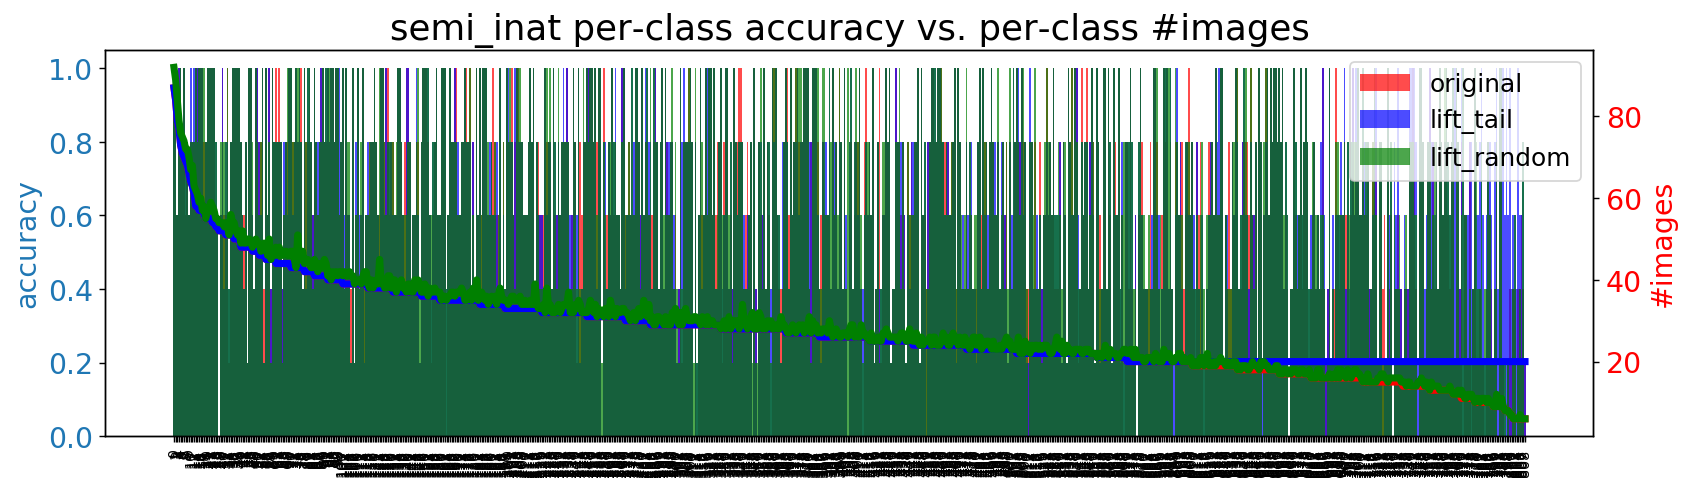

In [58]:
algo = 'debiased'
plot_per_class_accuracy(result_dict, dataset, index_name, algo, threshold)

Classes < 120 images: 65
Samples to lift = 1103 images
original has head macc 0.666792269612922; tail macc 0.6181538451176424; total macc 0.6416350603103638
lift_tail has head macc 0.6720549053833133; tail macc 0.6104615383423292; total macc 0.6405410170555115


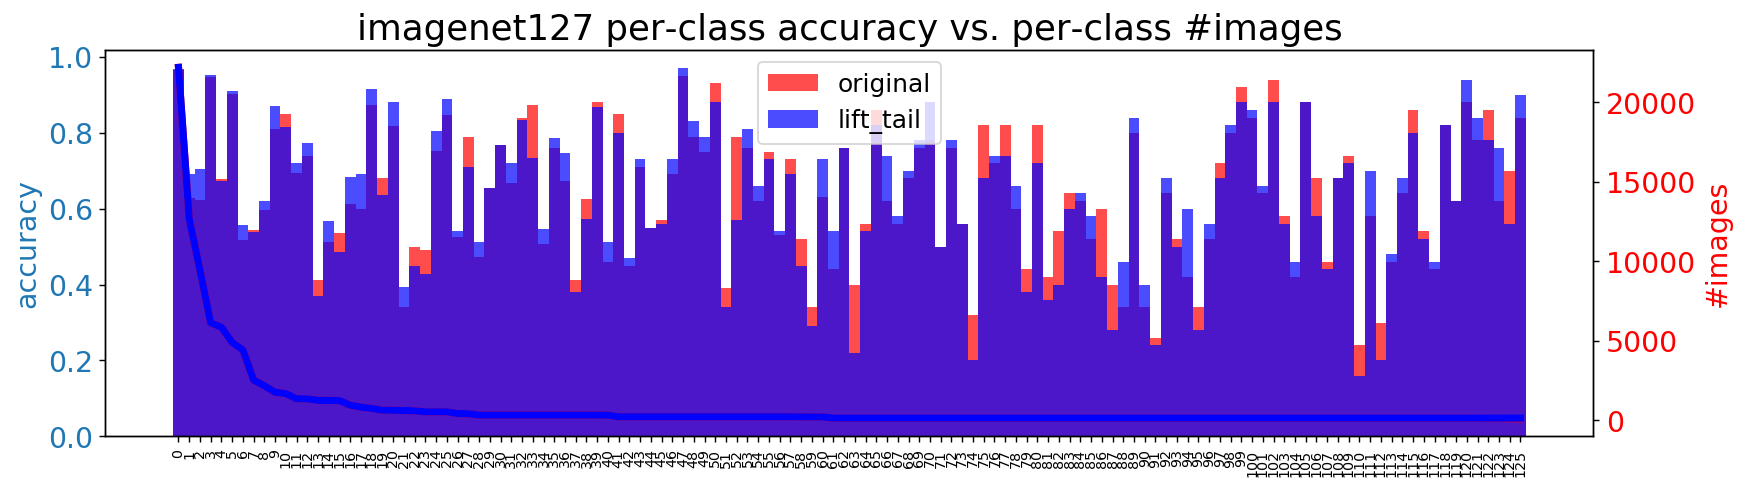

In [73]:
dataset = "imagenet127"
index_name = 'default'
algo = 'supervised'

threshold = 120
plot_per_class_accuracy(result_dict, dataset, index_name, algo, threshold)

Classes < 120 images: 65
Samples to lift = 1103 images
original has head macc 0.7121562005066481; tail macc 0.7415384622720572; total macc 0.7264689207077026


ValueError: shape mismatch: objects cannot be broadcast to a single shape

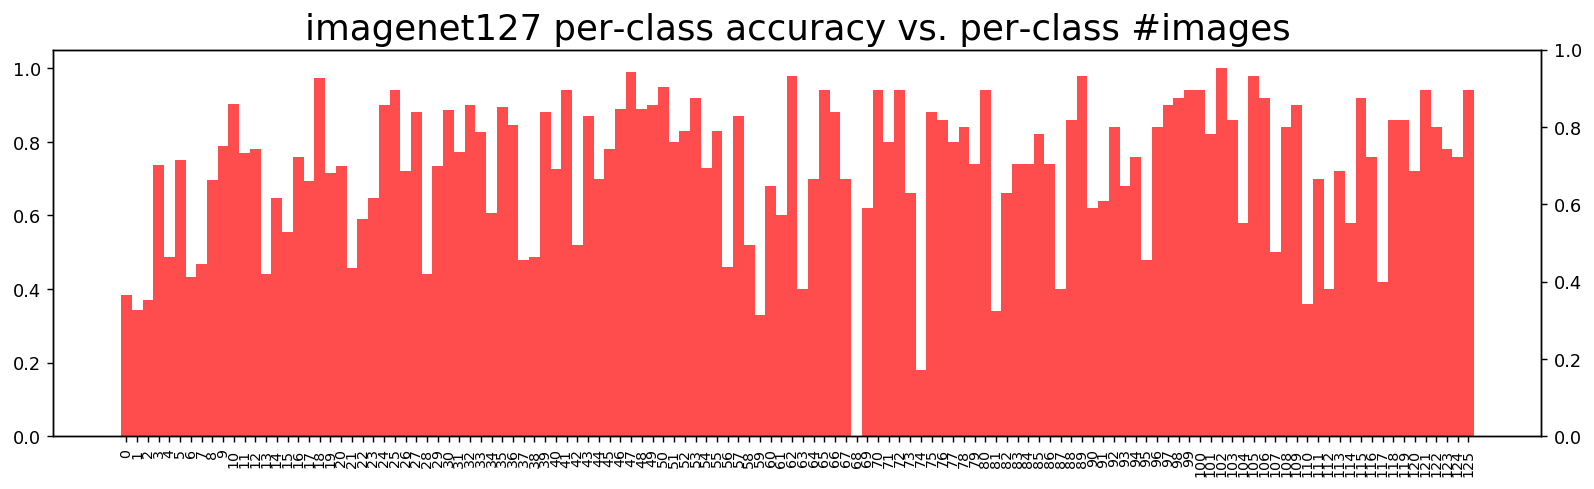

In [74]:
algo = 'debiased'
plot_per_class_accuracy(result_dict, dataset, index_name, algo, threshold)

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 50})
# Set default figure size.
plt.rcParams['figure.figsize'] = (40, 20)

def plot_bar(height, title, xlabel, ylabel, log_scale=False, mean=None, barcolor="#43C528",
             yticks=[10, 100, 300, 500, 1000, 2000, 5000]):

    fig, ax = plt.subplots()

    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=np.arange(len(height)),
        height=height,
        tick_label=["" for _ in height],
        color=barcolor,
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False, labelsize=30)
#     plt.xticks(rotation = 90)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    if log_scale:
        ax.set_yscale('log')
    
    if mean:
        ax.axhline(mean, color='g')
    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    yticks = np.array([min(height)] + yticks + [max(height)])
    ax.set_yticks(yticks, minor=False)
    ax.set_yticklabels(yticks, size=40)
    ax.set_xlabel(xlabel, labelpad=15, color='#333333', size=34)
    ax.set_ylabel(ylabel, labelpad=15, color='#333333', size=34)
    ax.set_title(title, pad=15, color='#333333', weight='bold')

    fig.tight_layout()
    plt.show()

In [ ]:
def plot_curves(d, title=None, xlabel=None, ylabel=None, log_scale=False, barcolor="#43C528",
                yticks=[]):
    fig, ax = plt.subplots()
    
    for k in d:
        ax.plot(d[k], label=k)
    ax.set_title(title, pad=15, color='#333333', weight='bold')
    ax.set_xlabel(xlabel, labelpad=15, color='#333333', size=34)
    ax.set_ylabel(ylabel, labelpad=15, color='#333333', size=34)
    if log_scale:
        ax.set_yscale('log')
    plt.legend()
    yticks = np.array([min([min(d[k]) for k in d])] + yticks + [max([max(d[k]) for k in d])])
    ax.set_yticks(yticks, minor=False)
    ax.set_yticklabels(yticks, size=40)
    ax.set_xlabel(xlabel, labelpad=15, color='#333333', size=34)
    ax.set_ylabel(ylabel, labelpad=15, color='#333333', size=34)
    ax.set_title(title, pad=15, color='#333333', weight='bold')
    fig.tight_layout()
    plt.show()

In [ ]:
def get_perclass_count(train_index_file, val_index_file, test_index_file, unlabeled_index_file, threshold=20):
    
    train_targets = np.array(pd.read_csv(train_index_file)['Target'].tolist())
    val_targets = np.array(pd.read_csv(val_index_file)['Target'].tolist())
    test_targets = np.array(pd.read_csv(test_index_file)['Target'].tolist())
    unlabeled_targets = np.array(pd.read_csv(unlabeled_index_file)['Target'].tolist())

    num_classes = max(test_targets)
    print("Number of class: " + str(num_classes))
    all_targets = np.concatenate((train_targets, val_targets, unlabeled_targets))
    all_perclass_count = [len(np.where(all_targets == i)[0]) for i in range(num_classes)]

    sorted_classes = [item[0] for item in sorted(enumerate(all_perclass_count), key=lambda x: x[1], reverse=True)]

    train_perclass_count = [len(np.where(train_targets == i)[0]) for i in range(num_classes)]
    val_perclass_count = [len(np.where(val_targets == i)[0]) for i in range(num_classes)]
    test_perclass_count = [len(np.where(test_targets == i)[0]) for i in range(num_classes)]
    unlabeled_perclass_count = [len(np.where(unlabeled_targets == i)[0]) for i in range(num_classes)]

    train_perclass_count = [train_perclass_count[idx] for idx in sorted_classes]
    val_perclass_count = [val_perclass_count[idx] for idx in sorted_classes]
    test_perclass_count = [test_perclass_count[idx] for idx in sorted_classes]
    unlabeled_perclass_count = [unlabeled_perclass_count[idx] for idx in sorted_classes]
    print("Unlabeled " + str(len(unlabeled_targets)))
    print("Train " + str(len(train_targets)))
    print("Val " + str(len(val_targets)))
    print("Test " + str(len(test_targets)))

    print("Unlabeled (min)" + str(min(unlabeled_perclass_count)))
    print("Train (min)" + str(min(train_perclass_count)))
    print("Val (min)" + str(min(val_perclass_count)))
    print("Unlabeled (max)" + str(max(unlabeled_perclass_count)))
    print("Train (max)" + str(max(train_perclass_count)))
    print("Val (max)" + str(max(val_perclass_count)))
    print(f"Classes <= {threshold} images: " + str(np.sum(np.array(train_perclass_count) <= threshold)))
    print(f"Classes < {threshold} images: " + str(np.sum(np.array(train_perclass_count) < threshold)))
    return train_perclass_count, val_perclass_count, test_perclass_count, unlabeled_perclass_count

In [ ]:
semi_inat_dir = "indexes/semi_inat"
train_index_file = os.path.join(semi_inat_dir, "default", "train.csv")
val_index_file = os.path.join(semi_inat_dir, "default", "val.csv")
unlabeled_index_file = os.path.join(semi_inat_dir, "default", "unlabeled.csv")
test_index_file = os.path.join(semi_inat_dir, "test.csv")

train_perclass_count, val_perclass_count, test_perclass_count, unlabeled_perclass_count = get_perclass_count(
    train_index_file, val_index_file, test_index_file, unlabeled_index_file, threshold=20)

In [ ]:
train_perclass_count = np.array(train_perclass_count)

print(np.sum((20-train_perclass_count)[train_perclass_count <= 20]))

In [ ]:
plot_curves({
    'Labeled' : train_perclass_count,
    'Val' : val_perclass_count,
    'Test' : test_perclass_count,
    'Unlabeled' : unlabeled_perclass_count
}, "Semi-iNat Class Distribution", "ClassID sorted by cardinality", "Num of images",  log_scale=False, barcolor="#43C528",
yticks=[10, 20, 30, 50, 70, 100, 150])

In [ ]:
plot_bar(train_perclass_count, "Train Set", "ClassID sorted by cardinality", "Num of images", log_scale=True, barcolor="#43C528",
         yticks=[10, 30, 50, 70, 100])

In [ ]:
imagenet127_dir = "indexes/imagenet127"
train_index_file = os.path.join(imagenet127_dir, "default", "train.csv")
val_index_file = os.path.join(imagenet127_dir, "default", "val.csv")
unlabeled_index_file = os.path.join(imagenet127_dir, "default", "unlabeled.csv")
test_index_file = os.path.join(imagenet127_dir, "test.csv")

train_perclass_count, val_perclass_count, test_perclass_count, unlabeled_perclass_count = get_perclass_count(
    train_index_file, val_index_file, test_index_file, unlabeled_index_file, threshold=150)

In [ ]:
plot_curves({
    'Labeled' : train_perclass_count,
    'Val' : val_perclass_count,
    'Test' : test_perclass_count,
    'Unlabeled' : unlabeled_perclass_count
}, "ImageNet127 Class Distribution", "ClassID sorted by cardinality", "Num of images",  log_scale=True, barcolor="#43C528",
yticks=[78, 872, 10000, 30000, 50000, 100000, 150000, 200000])

In [ ]:
print(test_perclass_count)

In [ ]:
# after lifting the tail
semi_inat_dir = "indexes/semi_inat"
train_index_file_lift_tail = os.path.join(semi_inat_dir, "default_lift_tail", "train.csv")
train_index_file = os.path.join(semi_inat_dir, "default", "train.csv")
train_index_file_lift_random = os.path.join(semi_inat_dir, "default_lift_random", "train.csv")
train_index_file_lift_random_2 = os.path.join(semi_inat_dir, "default_lift_random", "train.csv")

train_perclass_count_lift_tail, train_perclass_count, train_perclass_count_lift_random, _ = get_perclass_count(
    train_index_file_lift_tail, train_index_file, train_index_file_lift_random, train_index_file_lift_random, threshold=20)
plot_curves({
    'Lift Tail' : train_perclass_count_lift_tail,
    'Original' : train_perclass_count,
    'Lift Random' : train_perclass_count_lift_random,
}, "Semi-iNat Class Distribution", "ClassID sorted by cardinality", "Num of images",  log_scale=True, barcolor="#43C528",
yticks=[10, 20, 30, 50, 70, 100])

In [ ]:
# after lifting the tail
imagenet127_dir = "indexes/imagenet127"
train_index_file_lift_tail = os.path.join(imagenet127_dir, "default_lift_tail", "train.csv")
train_index_file = os.path.join(imagenet127_dir, "default", "train.csv")
train_index_file_lift_random = os.path.join(imagenet127_dir, "default_lift_random", "train.csv")
train_index_file_lift_random_2 = os.path.join(imagenet127_dir, "default_lift_random", "train.csv")

train_perclass_count_lift_tail, train_perclass_count, train_perclass_count_lift_random, _ = get_perclass_count(
    train_index_file_lift_tail, train_index_file, train_index_file_lift_random, train_index_file_lift_random, threshold=20)
plot_curves({
    'Lift Tail' : train_perclass_count_lift_tail,
    'Original' : train_perclass_count,
    'Lift Random' : train_perclass_count_lift_random,
}, "ImageNet127 Class Distribution", "ClassID sorted by cardinality", "Num of images",  log_scale=True, barcolor="#43C528",
yticks=[78, 872, 10000, 30000, 50000])